In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load and preprocess data
data = pd.read_csv("latest_binance_data.csv")
data = data.loc[:, ['date', 'high', 'low', 'open', 'volume', 'close']]
data = data.set_index('date')
data.index = pd.to_datetime(data.index, unit='ns')

In [3]:
# Define technical indicators
def compute_rsi(series, window):
    delta = series.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, fast=12, slow=26, signal=9):
    fast_ema = series.ewm(span=fast, min_periods=1).mean()
    slow_ema = series.ewm(span=slow, min_periods=1).mean()
    macd = fast_ema - slow_ema
    signal_line = macd.ewm(span=signal, min_periods=1).mean()
    macd_histogram = macd - signal_line
    return macd, signal_line, macd_histogram

def add_technical_indicators(df):
    df['MA_5'] = df['close'].rolling(window=5).mean()
    df['MA_10'] = df['close'].rolling(window=10).mean()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = compute_macd(df['close'])
    df = df.dropna()
    return df

data = add_technical_indicators(data)

In [4]:
# Plotting function
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Bitcoin/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

In [5]:
# Normalize data
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

In [6]:
# Extract window data
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [7]:
# Prepare data
def prepare_data(df, aim, window_len=10, zero_base=True, test_size=0.2):
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1
    
    return train_data, test_data, X_train, X_test, y_train, y_test

In [8]:
# Build GRU model
def build_gru_model(input_data, output_size, neurons, activ_func='linear',
                    dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [9]:
# Set random seed for reproducibility
np.random.seed(245)

In [10]:

# Set parameters
window_len = 5
test_size = 0.2
zero_base = True
neurons = 100
epochs = 50
batch_size = 64
dropout = 0.3
optimizer = 'adam'
loss = 'mse'
aim = 'close'

In [11]:

# Prepare data
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [12]:
# Build and train the model
model = build_gru_model(X_train, output_size=1, neurons=neurons, dropout=dropout, loss=loss, optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
modelfit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stopping])

Epoch 1/50


d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0289 - val_loss: 0.0105
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0268 - val_loss: 0.0117
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0304 - val_loss: 0.0066
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0182 - val_loss: 0.0053
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0184 - val_loss: 0.0029
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120 - val_loss: 0.0039
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - val_loss: 0.0037
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089 - val_loss: 0.0027
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - val_loss: 0.0037
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - val_l

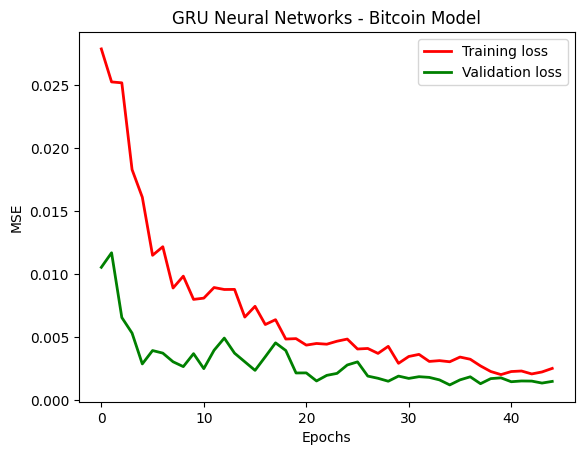

In [13]:
# Plot training and validation loss
plt.plot(modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.title('GRU Neural Networks - Bitcoin Model')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [14]:
# Evaluate the model
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
print(f'MAE: {mean_absolute_error(preds, y_test)}')
print(f'MSE: {mean_squared_error(preds, y_test)}')
print(f'R^2: {r2_score(y_test, preds) * 100}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
MAE: 0.029679932083931337
MSE: 0.0014902300346658535
R^2: 75.117466898247


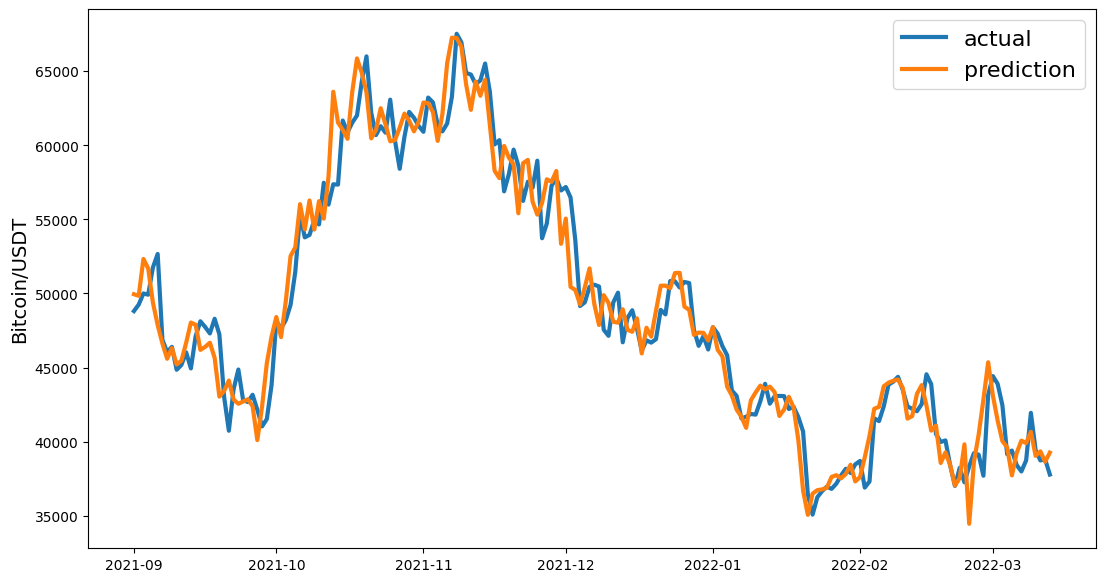

In [15]:
# Visualize predictions
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)